This file contains a CNN implementation for categorizing music by their genre, given their Mel spectrograms.

In [1]:
#Loading libraries

#Pytorch, plotting
import torch
import torchvision
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch import Tensor
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
from torch.utils.data import Subset

#General/other
from typing import Set, Tuple, List
import numpy as np
import random, time
from pathlib import Path
import os, math

#Loading functions

from tools import augment_training, plot_training_curve, get_model_name, get_correct, get_model_path, evaluate, seed_worker, load_randomized_loaders
from tools import save_features, train_classifier, genre_classifier, plot_confusion_matrix

#NOTE: In order to import 'tools', you need to add ./__Main__ to your PYTHONPATH env variables (otherwise you will get an import error).

We will now proceed to create training, validation, and testing loaders.

For this initial training, the team used the gtzan music dataset.
For more details on how the data was loaded and processed, please see the 'Spectrograms.ipynb' script.

torch.Size([3, 308, 775])


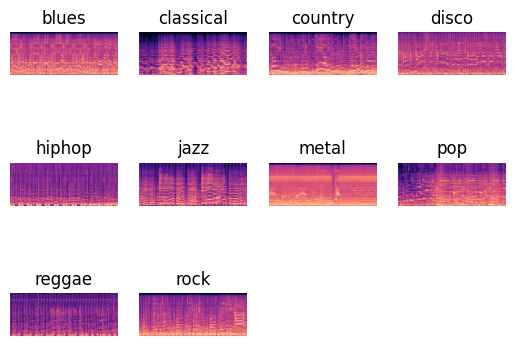

In [2]:
#Splitting into training, validation and testing datasets. Can provide randomizing seed, to help replicate results.

spectrograms_path: str = r'W:\school\aps360\APS360-Music-Genre-Classifier\__Main__\Mel_Spectrograms'

classification_dict: dict[int, str] = {0: 'blues', 1: 'classical', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}

train_loader, validation_loader, test_loader = load_randomized_loaders(data_path=spectrograms_path,
                                                                       batch_size=1, augment=False)

#Visualizing classes as spectrograms of the genres
seen_classes: Set[int] = set()
showed_shape: bool = False
for images, labels in train_loader:
    image: Tensor = images[0] #batch size of one, so just get single image in batch
    target_class: int = int(labels[0]) #getting current image's class
    if target_class not in seen_classes:
        seen_classes.add(target_class)
        #Image shape, values
        if not showed_shape:
            print(image.shape)
            showed_shape = True

        #Plotting
        image = np.transpose(image, [1,2,0]) #resetting image channel back to the end
        #resetting transformation
        img_max = image.max()
        img_min = image.min()
        image = (image - img_min) / (img_max - img_min)
        plt.subplot(3, 4, target_class+1)
        plt.axis('off')
        plt.title(classification_dict[target_class])
        plt.imshow(image)

The above is a visualization of the genres; it can already be seen that spectrograms show unique characteristics for each genre.

For example, the metal example is very loud, as shown on the high decibels on its corresponding spectrograms, while the reggae spectrogram is more 'relaxed'.

In [3]:
print(f"Training examples: {len(train_loader)}\nValidation examples: {len(validation_loader)}\nTesting examples: {len(test_loader)}")

Training examples: 799
Validation examples: 100
Testing examples: 100


Although the team will expand the number of examples in the future, we only have 1000 to work with right now.

These have been split into 80% training, 10% validation, and 10% testing.

In [4]:
#Importing VGG16, and modifying classifier.
vgg_16: nn.Module = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16_bn', pretrained=True)

Using cache found in C:\Users\Durango/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\Durango\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Durango\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


For this task, the 2014 ImageNet second place winner VGG 16 will be preloaded.

A slightly different classifier will be created for it.

In [ ]:
#Saving features for loaders
#Creating new loaders with batch size of 32

train_loader, validation_loader, test_loader = load_randomized_loaders(spectrograms_path, batch_size=32, augment=False, shuffle_seed=7)


train_vgg: List[Tuple[Tensor, Tensor]] = save_features(train_loader, vgg_16)
val_vgg: List[Tuple[Tensor, Tensor]] = save_features(validation_loader, vgg_16)
test_vgg: List[Tuple[Tensor, Tensor]] = save_features(test_loader, vgg_16)

In [7]:
for features, labels in train_vgg:
    print(features.shape)
    print(labels.shape)
    break

torch.Size([32, 512, 9, 24])
torch.Size([32])


We will now create a classifier for the extracted features. The classifier code is adapted from VGG16 (Simonyan, 2015).

In [8]:
classifier = genre_classifier(dropout_prob= 0.3, output_size= 512 * 9 * 24)
gpu: bool = True

if torch.cuda.is_available and gpu:
    classifier = classifier.cuda()

train_classifier(train_vgg, val_vgg, net=classifier, use_gpu=gpu, learning_rate=0.1*3*math.e**(-4), num_epochs=20)

Training on GPU 'NVIDIA GeForce RTX 2080 Ti'
Batch size: 32	Learning rate: 0.005494691666620257	Epochs: 20
Using dropout: 0.3
Weight decay: 0.0005
Epoch 1: Train acc: 0.3141426783479349, Train loss: 2.1825211000442506 |Validation acc: 0.44, Validation loss: 1.9320842623710632
Epoch 2: Train acc: 0.5882352941176471, Train loss: 1.3414878010749818 |Validation acc: 0.52, Validation loss: 1.3183458745479584
Epoch 3: Train acc: 0.8523153942428036, Train loss: 0.5435659682750702 |Validation acc: 0.46, Validation loss: 1.4106431603431702
Epoch 4: Train acc: 0.9762202753441802, Train loss: 0.154615338742733 |Validation acc: 0.72, Validation loss: 1.1983740776777267
Epoch 5: Train acc: 0.9962453066332916, Train loss: 0.04443638134747743 |Validation acc: 0.69, Validation loss: 1.0660429000854492
Epoch 6: Train acc: 1.0, Train loss: 0.018151852022856473 |Validation acc: 0.72, Validation loss: 0.8980781584978104
Epoch 7: Train acc: 1.0, Train loss: 0.010760705303400755 |Validation acc: 0.69, Valid

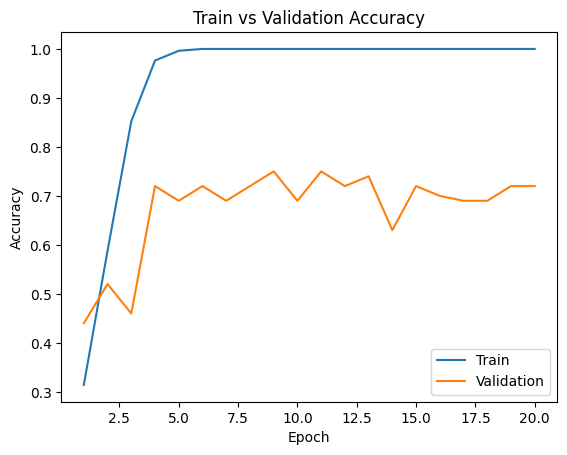

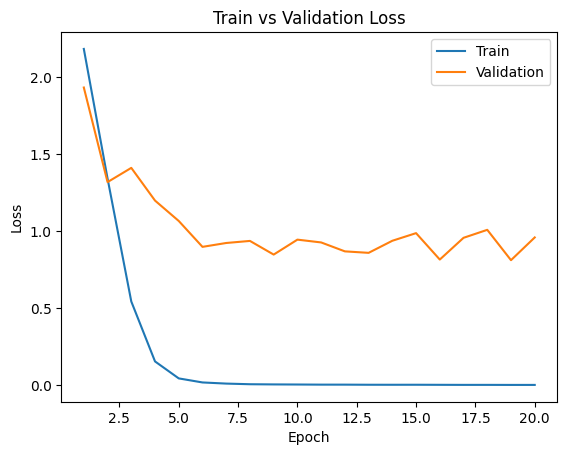

In [10]:
#Plotting results
classifier = genre_classifier(dropout_prob= 0.3, output_size = 512 * 9 * 24)

model_path = get_model_path(model = classifier, lr = 0.1*3*math.e**(-4), batch_size = 32, epoch = 20)
plot_training_curve(model_path)

We will now run the testing data with our best model.

In [11]:
#Loading best model
best_classifier = genre_classifier(dropout_prob=0.3, output_size= 9 * 24 * 512)

if torch.cuda.is_available:
    best_classifier = best_classifier.cuda()

model_path = get_model_path(best_classifier, 0.1*3*math.e**(-4), 32, 20, 11) #epoch 20 had the best validation accuracy
state = torch.load(model_path)
best_classifier.load_state_dict(state)

C:\Users\Durango\AppData\Local\Temp\ipykernel_17336\4094838860.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(model_path)


<All keys matched successfully>

In [13]:
#Testing best model

test_acc, test_loss = evaluate(best_classifier, test_vgg, criterion=nn.CrossEntropyLoss(), use_gpu=True)

print(f"Test accuracy: {test_acc}\nTest loss: {test_loss}")

Test accuracy: 0.79
Test loss: 0.9000492990016937


Plotting confusion matrix

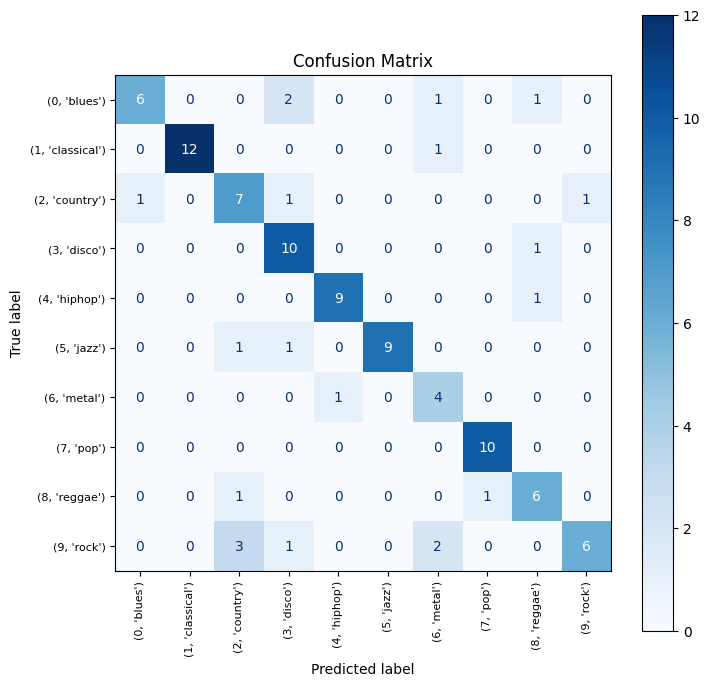

In [17]:
plot_confusion_matrix(best_classifier, test_vgg, classification_dict.items())

In [16]:
print(list(classification_dict.values()))

['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


Citations

[1] K. Simonyan and A. Zisserman, “Very deep convolutional networks for large-scale image recognition,” arXiv.org, https://doi.org/10.48550/arXiv.1409.1556 (accessed Nov. 3, 2024). 